##  Car Price Project - Algorithms

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import seaborn as sns
import re
import pprint
import joblib

#pd.set_option('max_colwidth', 2000)
pd.options.display.max_rows = 500
pd.options.display.max_columns = 500

#Distributions supporting rvs method
from scipy.stats import randint
from scipy.stats import uniform
from skopt.space import Real

#Feature selection
from eli5.sklearn import PermutationImportance
import eli5

#transformers
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

#Model selection
from sklearn.base import clone
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit

#Anomaly detection for outliers.
from sklearn.ensemble import IsolationForest

#Models for prediction
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import lightgbm as lgb

#Scoring
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

C:\Users\Justin\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
#Score predictions of fitted model.
def score_algo(model, X, y, prediction):
    print('-----------------------------------------------')
    print(f'##### {type(model).__name__} - Prediction Scores:')
    print('-----------------------------------------------')
    print('RMSE:', round(np.sqrt(mean_squared_error(y, prediction)), 1))
    print(' R^2:', round(r2_score(y, prediction), 4))
    print(' MAE:', round(mean_absolute_error(y, prediction),1))

In [3]:
import psycopg2
from sqlalchemy import create_engine
from sqlalchemy.dialects.postgresql import JSON, JSONB
engine=create_engine("postgresql://postgres@localhost:5432/postgres")

In [4]:
#Read in data tables.  Put quotes around table to make case-sensitive.
vehicle=pd.read_sql('SELECT * from vehicle', engine, index_col='index')
train=pd.read_sql('SELECT * from "trainClean"', engine, index_col='index')
test=pd.read_sql('SELECT * from "testClean"', engine, index_col='index')
vehicle.index.name=None; train.index.name=None; test.index.name=None;

##  Nonlinear Models - LightGBM

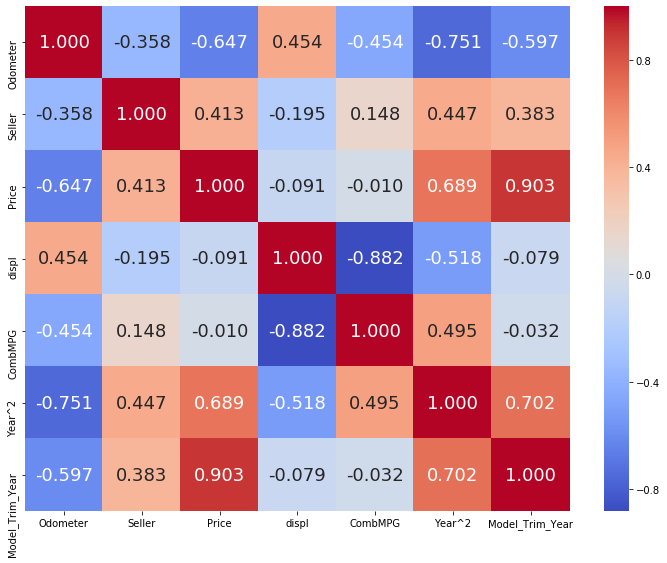

In [5]:
#Show correlation heatmap.  Keeping the collinear features may help prediction, while making the 
#linear regression coefficients less interpretable.
plt.figure(figsize=(10,8))
sns.heatmap(train.corr(), cmap='coolwarm', annot=True, annot_kws={"size": 18}, fmt=".3f")
plt.tight_layout()

<a id='section_id1'></a>

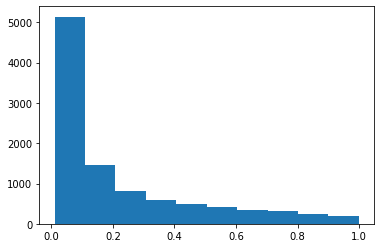

In [6]:
#Log uniform distribution from scikit-optimize
plt.hist(Real(0.01, 1.0, 'log-uniform').rvs(n_samples=10000))
plt.show()

### LightGBM model

In [7]:
#Split out Price
trainX = train.copy()
trainY = trainX.pop('Price')
testX = test.copy()
testY = testX.pop('Price')
display('Input data:', trainX.head(2))

#CREATE LightGBM model with random search.

clf = lgb.LGBMRegressor(boosting_type='gbdt', objective='regression', n_jobs=1, silent=1)

param_grid={"learning_rate": Real(0.01, 1.0, 'log-uniform'),
            "n_estimators": randint(100,200),
            "num_leaves": randint(2, 600), 
            "max_depth": randint(0, 40),
            "min_data_in_leaf": randint(10, 200),  #prevents overfitting
            "max_bin": randint(100,60000),
            "bagging_fraction": Real(0.01, 0.1, 'uniform'),
            "feature_fraction": uniform(0.01, 0.99),
            "subsample_for_bin": randint(100000, 600000),
            "lambda_l2": Real(1e-9, 1000, 'log-uniform'),
            "lambda_l1": Real(1e-9, 1, 'log-uniform'),          
            }

#Instantiate random_search.
lgb_model = RandomizedSearchCV(clf, param_distributions=param_grid, n_iter=30, cv=5, n_jobs=-1, refit=True,\
                           scoring='neg_mean_absolute_error', return_train_score=False,random_state=40)

#Tune model with CV. Model will automatically refit on full train with best parameters.
lgb_model.fit(trainX, trainY)

#Tuned model best score.
best_score_std = lgb_model.cv_results_['std_test_score'][lgb_model.best_index_]
print(f'## Grid iters checked: {len(lgb_model.cv_results_["params"])}','\n')
mean_score = np.round(lgb_model.cv_results_["mean_test_score"],0)
print(f'## mean valid scores: {mean_score})', '\n')
print(f'## best valid score: {lgb_model.best_score_:.0f} +- {best_score_std:.0f}','\n')   
print('## Best parameters:')
pprint.pprint(lgb_model.best_params_)
print('\n')

#PREDICT model on full data (thanks to refit).
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
y_test_pred = lgb_model.predict(testX)
score_algo(lgb_model, testX, testY, y_test_pred)  

#Get feature importances using eli5.
perm = PermutationImportance(lgb_model, n_iter=20).fit(testX, testY)
display(eli5.show_weights(perm, feature_names = testX.columns.tolist()))


'Input data:'

,Odometer,Seller,displ,CombMPG,Year^2,Model_Trim_Year
7815,125769.0,15686.776221,4.35,21.0,4052169.0,9103.878106
9831,51049.0,15686.776221,2.35,22.0,4064256.0,18863.391554


## Grid iters checked: 30 

## mean valid scores: [-2186. -2158. -2094. -2324. -2168. -2325. -2458. -2167. -2175. -3209.
 -2460. -2091. -2220. -3830. -2129. -2234. -2086. -2136. -2115. -2103.
 -2133. -2094. -2602. -2300. -3146. -2064. -2081. -2113. -2096. -2077.]) 

## best valid score: -2064 +- 53 

## Best parameters:
{'bagging_fraction': array([0.08644627]),
 'feature_fraction': 0.6784060708074386,
 'lambda_l1': array([1.34453395e-05]),
 'lambda_l2': array([1.35849293e-07]),
 'learning_rate': array([0.08686539]),
 'max_bin': 35280,
 'max_depth': 5,
 'min_data_in_leaf': 78,
 'n_estimators': 158,
 'num_leaves': 481,
 'subsample_for_bin': 206678}


-----------------------------------------------
##### RandomizedSearchCV - Prediction Scores:
-----------------------------------------------
RMSE: 3155.4
 R^2: 0.8811
 MAE: 2085.6


Weight,Feature
4432.3870 ± 429.8695,Model_Trim_Year
1485.0890 ± 139.1460,Odometer
526.5501 ± 102.8994,Year^2
409.4648 ± 70.0269,CombMPG
285.5908 ± 86.3036,displ
198.7330 ± 45.9798,Seller


#### Residuals Plot Function

In [8]:
def plot_residuals(predicted, true):
    '''
    Plots predicted vs error.  Error = true - predicted.  Marks
    three standard deviation error from mean with orange bars.  
    Plots error histogram.  Plots regression of predicted vs true.
    Returns indices of 3 sigma anomalies.
    '''
    anomaly_locs = []
    error = true - predicted
    print('error count:', len(error), '| error avg:', round(error.mean(),1), '| high pred percent:', round(100*len(error[error<0])/len(error),1), '| low pred percent:', round(100*len(error[error>=0])/len(error),1), )
    mean = np.mean(error)
    three_std = 3* np.std(error)
    upper_lim = mean + three_std; lower_lim = mean - three_std;
    sns.set(font_scale=1.3)
    fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(10,30))
    sns.scatterplot(x=predicted, y=error, ax=ax1, color='black')    
    ax1.set_title('Scatterplot: Predicted vs Error')
    ax1.set_xlabel('Predicted'); ax1.set_ylabel('Error - True less Predicted');
    ax1.axhline(y=0, color='g', ls='--', alpha=0.8)
    ax1.axhline(y=upper_lim, color='orange', ls='--', alpha=0.8)
    ax1.axhline(y=lower_lim, color='orange', ls='--', alpha=0.8)
    
    for elem in range(0, predicted.shape[0]):  #add iloc for error outside limits. 's=' is the text string.
        x_val = predicted[elem]     #assume predicted is numpy.ndarray
        y_val = error.values[elem]  #assume error is Series
        label_str = str(true.iloc[elem:elem+1].index[0])  #loc
        if (y_val > upper_lim or y_val < lower_lim):
            anomaly_locs.append(true.iloc[elem:elem+1].index[0])
            ax1.text(x=x_val+500, y=y_val-400, s=label_str, horizontalalignment = 'left', size=14, color='r')
    
    sns.distplot(error, ax=ax2, kde=True)
    ax2.set_title('Histogram: Error - True Less Predicted')
    ax2.set_xlabel('Error'); ax2.set_ylabel('Frequency');
    ax2.axvline(x=0, color='black', ls='--', alpha=0.8)
    
    sns.regplot(x=predicted, y=true, ax=ax3, color='black', marker='.', ci=None)
    ax3.set_title('Linear Regression Plot: Predicted vs True')
    ax3.set_xlabel('Predicted'); ax3.set_ylabel('True');
    return anomaly_locs

In [9]:
train.head(2)

,Odometer,Seller,Price,displ,CombMPG,Year^2,Model_Trim_Year
7815,125769.0,15686.776221,9995.0,4.35,21.0,4052169.0,9103.878106
9831,51049.0,15686.776221,21495.0,2.35,22.0,4064256.0,18863.391554


In [10]:
# #Review loc
# pd.set_option('max_colwidth', 100)
# for locNum in [4777]:
#     iloc = np.where(trainX.index==locNum)[0][0]
#     display('### modeled train:', trainX.loc[[locNum]])
#     print('true:', trainY.loc[locNum])
#     print('predicted:', y_trn_pred[iloc])
#     print('error:', trainY.loc[locNum] - y_trn_pred[iloc])
#     display('### original:', vehicle.loc[[locNum]])
#     display(vehicle.loc[locNum,'Body'])
#     print('@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@')

error count: 4109 | error avg: 0.0 | high pred percent: 52.8 | low pred percent: 47.2


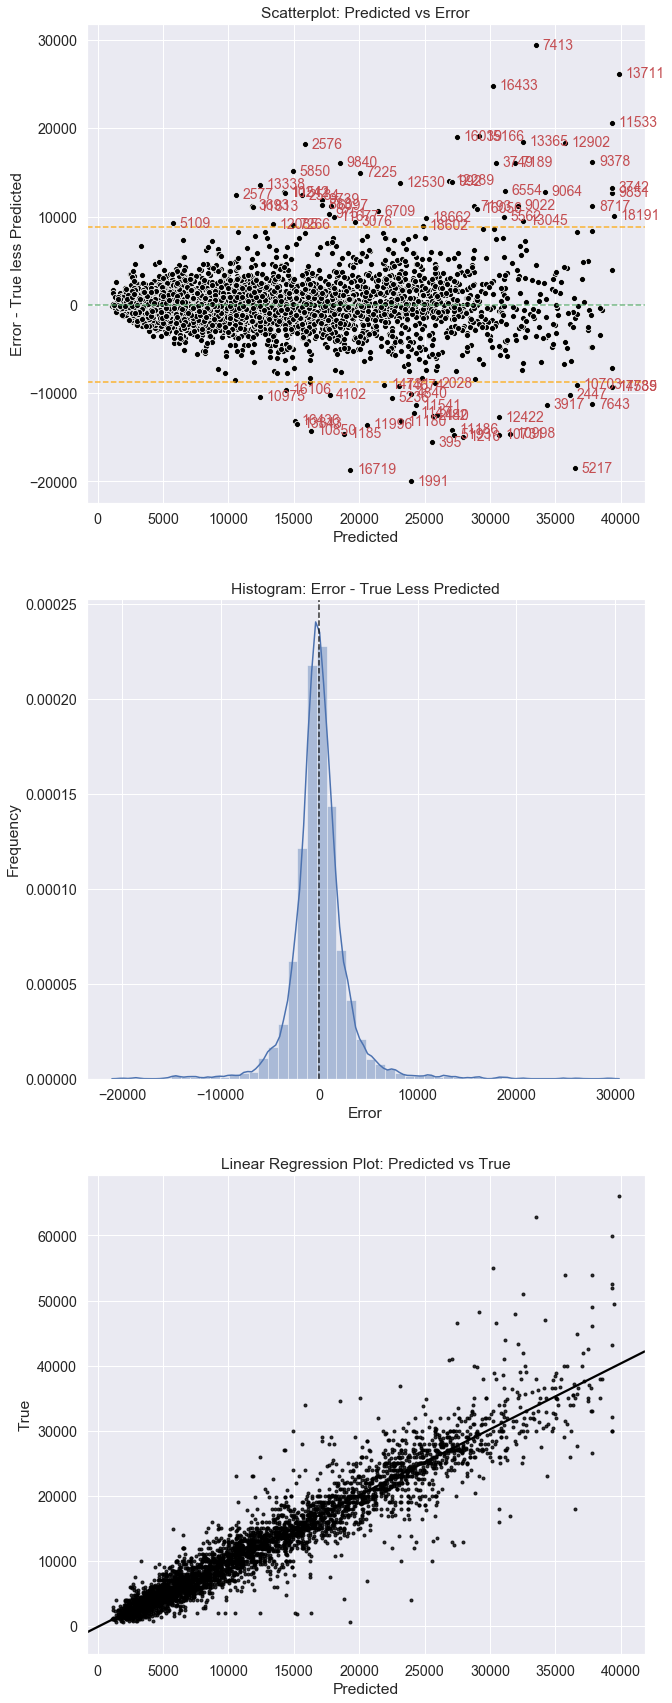

In [11]:
#LightGBM - Plot train residuals.
y_trn_pred = lgb_model.predict(trainX)
anomal = plot_residuals(predicted=y_trn_pred, true=trainY)

error count: 455 | error avg: -109.0 | high pred percent: 51.4 | low pred percent: 48.6


[10495, 17701, 12897, 10403, 17850, 15182, 4351, 17335, 7420]

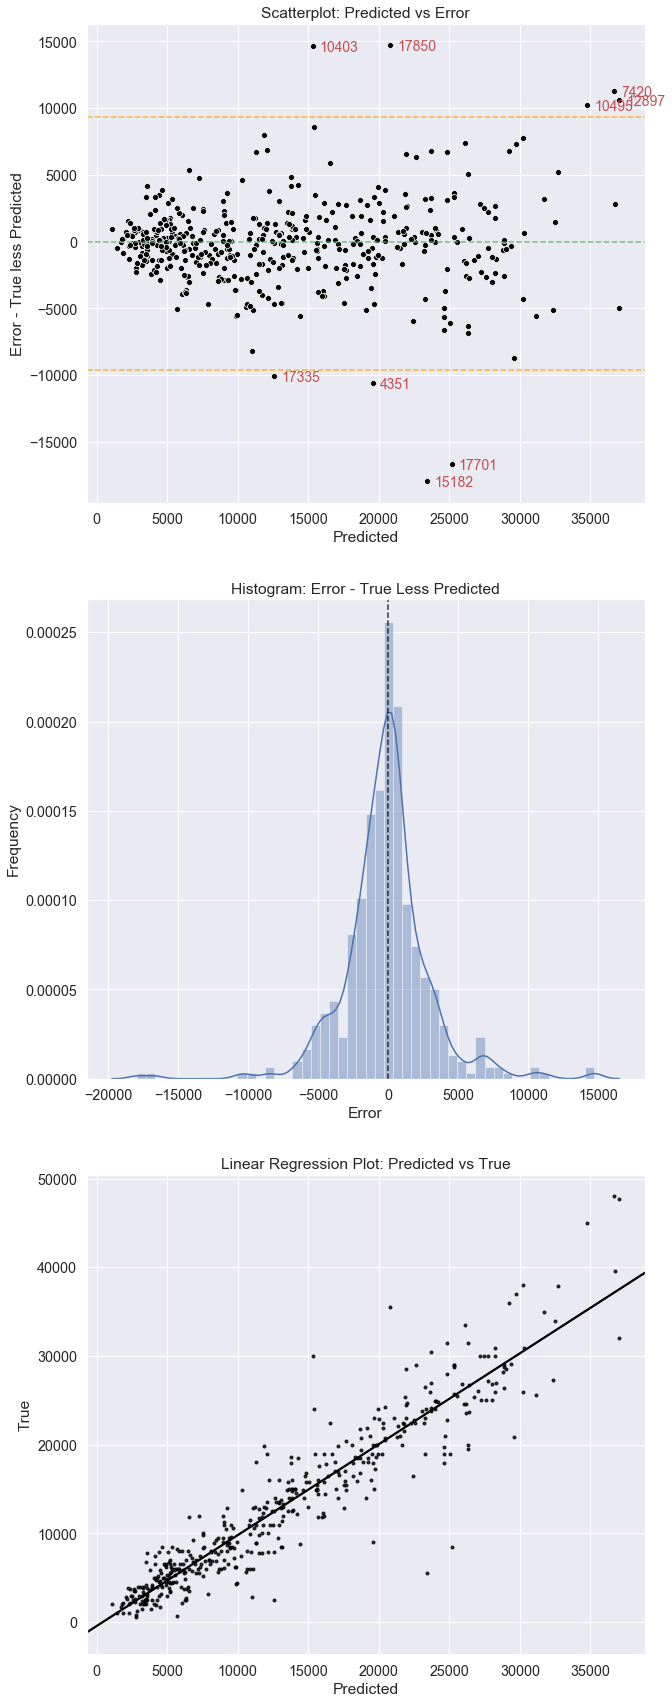

In [12]:
#LightGBM - Plot test residuals.
plot_residuals(predicted=y_test_pred, true=testY)

## Linear Regression Model

In [13]:
train=pd.read_sql('SELECT * from "trainClean"', engine, index_col='index')
test=pd.read_sql('SELECT * from "testClean"', engine, index_col='index')
train.index.name=None; test.index.name=None; 
train.shape

(4109, 7)

In [14]:
train.head(1)

,Odometer,Seller,Price,displ,CombMPG,Year^2,Model_Trim_Year
7815,125769.0,15686.776221,9995.0,4.35,21.0,4052169.0,9103.878106


In [15]:
#Split out Price
trainX = train.copy()
trainY =trainX.pop('Price')
testX = test.copy()
testY = testX.pop('Price')

In [16]:
def scale_num_df(train_df, test_df, numer_cols, scaler):
    '''Scale train.  Transform test with the same scaling stats.
    Returns scaled train and scaled test.'''
    from sklearn.preprocessing import RobustScaler
    scaled_trn_num_df = pd.DataFrame(scaler.fit_transform(train_df[numer_cols]))
    scaled_trn_num_df.index=train_df.index
    scaled_trn_num_df.columns=train_df[numer_cols].columns
    
    scaled_tst_num_df = pd.DataFrame(scaler.transform(test_df[numer_cols]))
    scaled_tst_num_df.index=test_df.index
    scaled_tst_num_df.columns=test_df[numer_cols].columns
    return scaled_trn_num_df, scaled_tst_num_df

#Standard scale so regression coefficient units are the same.
trainX, testX = scale_num_df(trainX.copy(), testX.copy(), trainX.columns, StandardScaler())

In [17]:
trainX.describe().round(2)

,Odometer,Seller,displ,CombMPG,Year^2,Model_Trim_Year
count,4109.00,4109.00,4109.00,4109.00,4109.00,4109.00
mean,0.00,-0.00,-0.00,-0.00,0.00,0.00
std,1.00,1.00,1.00,1.00,1.00,1.00
min,-1.79,-1.33,-1.79,-1.62,-3.19,-1.44
25%,-0.81,-1.33,-0.94,-0.75,-0.70,-0.83
50%,-0.06,0.75,0.00,-0.21,0.26,-0.15
75%,0.72,0.75,0.76,0.56,0.84,0.59
max,5.03,0.75,1.80,2.96,1.61,4.61


## `Tune Linear Models with Cross Validation`

In [20]:
def train_and_valid(what_model, num_folds, X, y):
    fold_rmse=[]
    kf=KFold(n_splits=num_folds, shuffle=True, random_state=30)    
        
    for train_index, valid_index in kf.split(X):
        #Clone is a model copy not yet fit on the data.  Initial conditions impact certain model results, like SGD.
        clone_model = clone(what_model)                                  
        trn_X, valid_X = X.iloc[train_index, :], X.iloc[valid_index, :]  #df has columns
        trn_y, valid_y = y.iloc[train_index], y.iloc[valid_index]        #series no columns
        clone_model.fit(trn_X, trn_y)
        valid_pred=clone_model.predict(valid_X)
        fold_rmse.append(round(np.sqrt(mean_squared_error(valid_y, valid_pred)), 2))
        
    print(f'***Tune {type(what_model).__name__}***\n## Fold RMSE:', fold_rmse)
    print('## Avg RMSE:', round(np.mean(fold_rmse),1),'+-', round(np.std(fold_rmse),1))
    print('## Clone R^2:', round(clone_model.score(X,y),3))
    return clone_model

In [21]:
#Linear regression finds the coeficcients that minimize the residual sum of squares.
lr=LinearRegression(fit_intercept=True)
lr_clone=train_and_valid(what_model=lr, num_folds=10, X=trainX, y=trainY)

***Tune LinearRegression***
## Fold RMSE: [2964.76, 3754.31, 3665.07, 3170.02, 3069.79, 4325.43, 3189.19, 3833.66, 3526.39, 3870.9]
## Avg RMSE: 3537.0 +- 410.6
## Clone R^2: 0.845


In [22]:
#Score last lr_clone on train (same data it was fitted on once).
y_pred_clone = lr_clone.predict(trainX)
score_algo(lr_clone, trainX, trainY, y_pred_clone)

-----------------------------------------------
##### LinearRegression - Prediction Scores:
-----------------------------------------------
RMSE: 3554.3
 R^2: 0.8449
 MAE: 2225.3


In [23]:
#Get LinearRegression feature importances.  Note: collinearity distorts feature importances.
perm = PermutationImportance(lr_clone,n_iter=20).fit(trainX, trainY)
eli5.show_weights(perm, feature_names = trainX.columns.tolist())

Weight,Feature
0.9461 ± 0.0264,Model_Trim_Year
0.0904 ± 0.0062,Odometer
0.0468 ± 0.0040,CombMPG
0.0170 ± 0.0017,Year^2
0.0060 ± 0.0011,Seller
0.0007 ± 0.0003,displ


## `Linear Model Predictions - Fit on 100% of train`

In [24]:
linregr=LinearRegression(fit_intercept=True)  #no scaling required for closed-form solution, only for coefficient
linregr.fit(trainX, trainY)
y_pred_linregr=linregr.predict(testX)
score_algo(linregr, testX, testY, y_pred_linregr)

-----------------------------------------------
##### LinearRegression - Prediction Scores:
-----------------------------------------------
RMSE: 3480.5
 R^2: 0.8554
 MAE: 2463.6


In [25]:
#Linear Regression Coefficients. Each feature has the same scale: value per unit of standard deviation.
pd.DataFrame({'feature': trainX.columns, 'coef' : np.round(linregr.coef_,2)})

,feature,coef
0,Odometer,-1914.90
1,Seller,478.10
2,displ,-148.80
3,CombMPG,-1368.25
4,Year^2,815.64
5,Model_Trim_Year,6198.31


error count: 455 | error avg: -94.9 | high pred percent: 52.5 | low pred percent: 47.5


[12897, 10403, 17850, 15182, 17335]

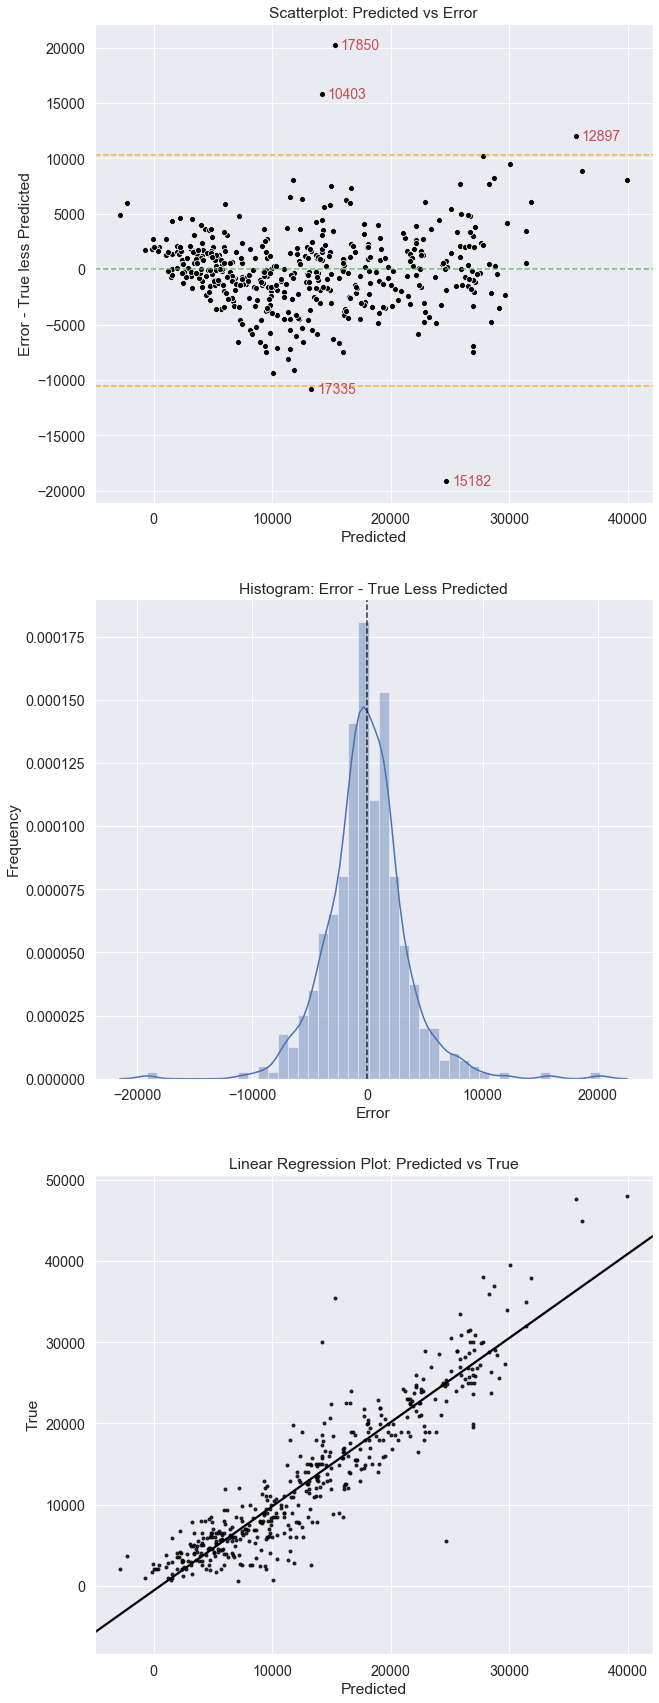

In [26]:
#Get test residuals.  A non-normal error means errors are not random.  Are there outliers?  Try transforming features
#to make them closer to normally distributed.  We will not go down this path today as we have a more accurate LightGBM
#model with better-looking residuals.  LightGBM can model non-linear relationships, in contrast to a linear regression.
plot_residuals(predicted=y_pred_linregr, true=testY)